In [1]:
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPooling2D
from tensorflow.keras.layers import Flatten,Dense,Dropout
from tensorflow.keras.optimizers import Adam, RMSprop
#from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
gen = ImageDataGenerator(rotation_range=20,
                         shear_range=0.2,
                         width_shift_range=0.2,
                         height_shift_range=0.2,
                         horizontal_flip=True)

In [3]:
# CIFAR-10 데이터셋을 읽고 신경망에 입력할 형태로 변환
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

x_train = x_train.astype(np.float32) / 255.0
x_test = x_test.astype(np.float32) / 255.0

In [4]:
# 보강할 학습데이터 이미지 생성

augment_ratio = 1.5   # 전체 데이터의 150%
augment_size = int(augment_ratio * x_train.shape[0])

print(augment_size)

# 전체 x_train 개수의 150% 비율만큼
randidx = np.random.randint(x_train.shape[0], size=augment_size)

# 임의로 선택된 데이터는 원본데이터를 참조하기 때문에
# 원본데이터에 영향을 줄수 있음. 그래서 copy() 함수를 통해 안전하게 복사본 만듬
x_augmented = x_train[randidx].copy()  
y_augmented = y_train[randidx].copy()

print(x_augmented.shape, y_augmented.shape)

#  이미지 보강 실행
x_augmented, y_augmented = gen.flow(x_augmented, y_augmented, 
                                    batch_size=augment_size,
                                    shuffle=False).next()

print(x_augmented.shape, y_augmented.shape)

75000
(75000, 32, 32, 3) (75000, 1)
(75000, 32, 32, 3) (75000, 1)


In [5]:
# x_train, y_train 에 보강된 데이터 추가

x_train = np.concatenate( (x_train, x_augmented) )
y_train = np.concatenate( (y_train, y_augmented) )

print(x_train.shape, y_train.shape)

(125000, 32, 32, 3) (125000, 1)


relu + Adam + (3,3)

In [8]:
# CNN 모델 구축

cnn=Sequential()

cnn.add(Conv2D(32,(3,3),activation='relu', padding='same',input_shape=(32,32,3)))
cnn.add(Conv2D(32,(3,3),activation='relu', padding='same'))
cnn.add(MaxPooling2D(pool_size=(2,2)))
cnn.add(Dropout(0.25))

cnn.add(Conv2D(64,(3,3),activation='relu', padding='same'))
cnn.add(Conv2D(64,(3,3),activation='relu', padding='same'))
cnn.add(MaxPooling2D(pool_size=(2,2)))
cnn.add(Dropout(0.25))

cnn.add(Conv2D(128,(3,3),activation='relu', padding='same'))
cnn.add(MaxPooling2D(pool_size=(2,2)))
cnn.add(Dropout(0.25))
cnn.add(Conv2D(128,(3,3),activation='relu', padding='same'))
cnn.add(MaxPooling2D(pool_size=(2,2)))
cnn.add(Dropout(0.25))
cnn.add(Conv2D(256,(3,3),activation='relu', padding='same'))
cnn.add(MaxPooling2D(pool_size=(2,2)))
cnn.add(Dropout(0.25))

cnn.add(Flatten())

cnn.add(Dense(128,activation='relu'))
cnn.add(Dropout(0.5))
cnn.add(Dense(10,activation='softmax'))

cnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 64)          0

In [10]:
from datetime import datetime

start_time = datetime.now()

cnn.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

hist = cnn.fit(x_train, y_train, batch_size=256, 
               epochs=250, validation_data=(x_test, y_test))

end_time = datetime.now()

print('Elapsed Time => ', end_time-start_time)

Epoch 1/250
489/489 [==============================] - 215s 439ms/step - loss: 1.7921 - accuracy: 0.3293 - val_loss: 1.3308 - val_accuracy: 0.5097
Epoch 2/250
489/489 [==============================] - 17s 35ms/step - loss: 1.3544 - accuracy: 0.5139 - val_loss: 1.0673 - val_accuracy: 0.6184
Epoch 3/250
489/489 [==============================] - 12s 24ms/step - loss: 1.1650 - accuracy: 0.5897 - val_loss: 0.9829 - val_accuracy: 0.6492
Epoch 4/250
489/489 [==============================] - 7s 14ms/step - loss: 1.0504 - accuracy: 0.6351 - val_loss: 0.7954 - val_accuracy: 0.7188
Epoch 5/250
489/489 [==============================] - 7s 14ms/step - loss: 0.9720 - accuracy: 0.6630 - val_loss: 0.7319 - val_accuracy: 0.7453
Epoch 6/250
489/489 [==============================] - 7s 14ms/step - loss: 0.9093 - accuracy: 0.6871 - val_loss: 0.7246 - val_accuracy: 0.7445
Epoch 7/250
489/489 [==============================] - 7s 14ms/step - loss: 0.8640 - accuracy: 0.7046 - val_loss: 0.6604 - val_accu

In [11]:
cnn.evaluate(x_test, y_test)

313/313 [==============================] - 1s 4ms/step - loss: 0.4229 - accuracy: 0.8721


[0.4228985011577606, 0.8720999956130981]

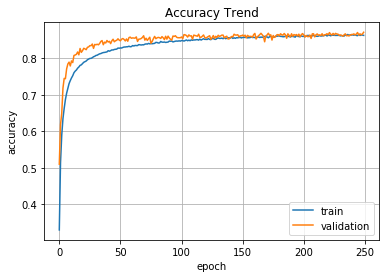

In [12]:
import matplotlib.pyplot as plt

plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Accuracy Trend')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','validation'], loc='best')
plt.grid()
plt.show()

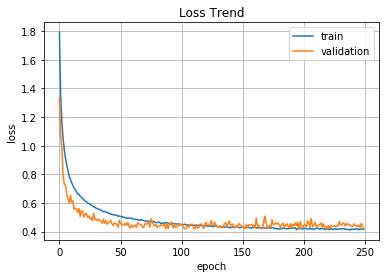

In [13]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Loss Trend')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','validation'], loc='best')
plt.grid()
plt.show()